In [9]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
import numpy as np
from torch import FloatTensor
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler

In [10]:

def generate_compact_dataset():
    # Set the mean for normal groups (same for all normal groups)
    np.random.seed(20) 
    mean_normal = np.array([0, 0])

    base_cov_normal =  [[1.1, 1], [1, 1.1]]

    angle_rad = np.radians(90)

    # Create the rotation matrix for 2D
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])

    # Set the mean for outlier groups (far from the normal groups)
    mean_outlier = np.array([5, 10])

    # Covariance matrix for outliers (wider spread)
    cov_matrix_rot = rotation_matrix @ base_cov_normal @ rotation_matrix.T

    # Generate 18 normal groups with different variances
    normal_groups = []
    for i in range(18):
        data_normal = np.random.multivariate_normal(mean_normal, base_cov_normal, 20)
        normal_groups.append((data_normal))

    # Generate 2 outlier groups with a different covariance (wider spread)
    outlier_group_1 = np.random.multivariate_normal(mean_normal, cov_matrix_rot, 20)
    outlier_group_2 = np.random.multivariate_normal(mean_normal+[5,0], cov_matrix_rot, 20)

    # Combine all groups
    all_groups = normal_groups + [(outlier_group_1), (outlier_group_2)]

    return all_groups

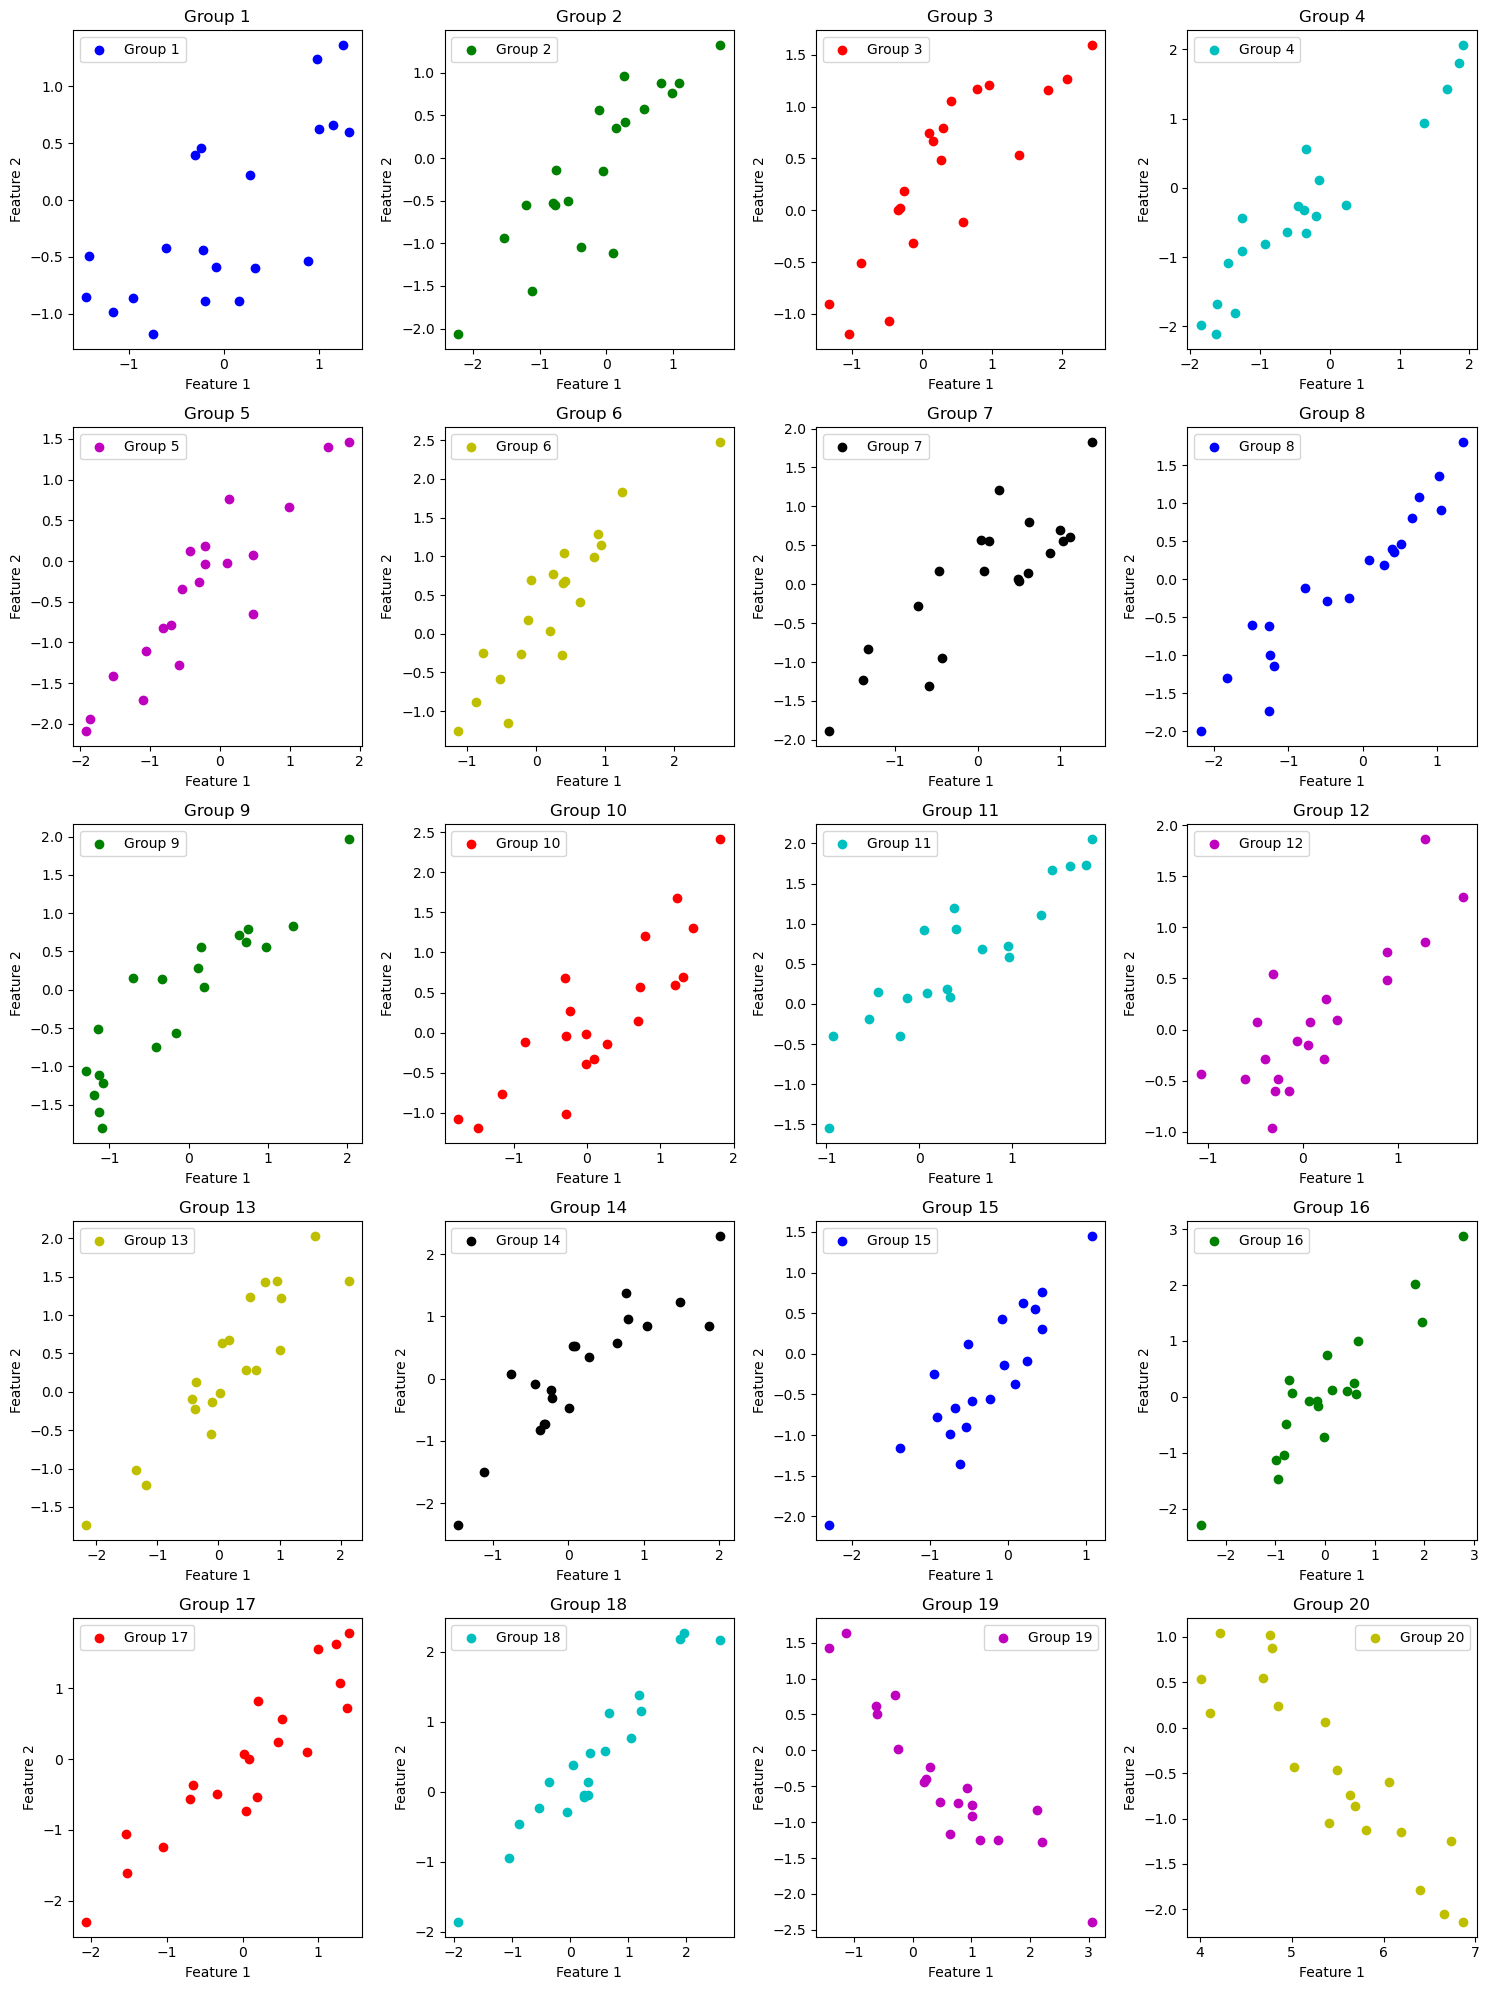

<Figure size 640x480 with 0 Axes>

In [12]:
def plot_all_groups_subplots(groups):
    # Create a figure with 5 rows and 4 columns (to fit 20 subplots)
    fig, axes = plt.subplots(5, 4, figsize=(15, 20))
    
    # Flatten axes array to easily index it
    axes = axes.flatten()

    # Different colors for each group
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * 3  # Repeat colors for 20 groups
    
    for idx, (group, ax) in enumerate(zip(groups, axes)):
        ax.scatter(group[:, 0], group[:, 1], color=colors[idx], label=f"Group {idx + 1}")
        ax.set_title(f"Group {idx + 1}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.legend()

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()
    plt.savefig("dataset.pdf")

# Generate the dataset
datasets = generate_compact_dataset()

# Plot all groups on different subplots
plot_all_groups_subplots(datasets)

In [33]:
datasets

[array([[-0.94951767, -0.86192417],
        [ 0.15760338, -0.8903352 ],
        [ 0.98647072,  1.23677451],
        [-0.7438746 , -1.18146463],
        [-0.60639789, -0.42464382],
        [-0.22111888, -0.44177893],
        [ 0.9999349 ,  0.62321651],
        [ 1.2561565 ,  1.36604366],
        [-0.3052471 ,  0.39581949],
        [-1.16793263, -0.98619915],
        [ 0.88605006, -0.5404284 ],
        [-1.44581228, -0.84977574],
        [ 0.27842379,  0.22027228],
        [-0.2362643 ,  0.45968343],
        [ 0.33022524, -0.59414233],
        [ 1.15435196,  0.66036899],
        [-1.41649733, -0.49530977],
        [ 1.3187019 ,  0.59735075],
        [-0.19324908, -0.88692241],
        [-0.08361811, -0.59188823]]),
 array([[ 0.27507841,  0.41862091],
        [ 0.2717703 ,  0.96259382],
        [-0.79566004, -0.53036524],
        [-0.7524524 , -0.14523069],
        [-1.53652759, -0.93198596],
        [ 0.09909175, -1.11033716],
        [ 0.56855883,  0.56923348],
        [-1.2094536 , -0.5

In [34]:
classifier = OneClassSMMClassifier(nu=0.1)
classifier.fit(datasets)
# classifier = OneClassSMM(0.1, 0.5)

In [35]:
decision, y_pred = classifier.predict(datasets)

In [36]:
decision

array([  1.99137735,   1.74494516,   1.57757202,   0.21506151,
         1.38744345,   2.1208091 ,   1.90970429,   1.20920386,
         1.57757552,   1.64635411,   1.59238774,   3.62847213,
         1.577572  ,   1.18210899,   2.9535421 ,   1.47977548,
         1.23964583,   1.1569522 ,  -1.93555363, -10.19154584])

In [37]:
y_pred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1.])

In [44]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[18, 19]

In [38]:
tensor_datasets = torch.tensor(datasets)
tensor_datasets

tensor([[[-9.4952e-01, -8.6192e-01],
         [ 1.5760e-01, -8.9034e-01],
         [ 9.8647e-01,  1.2368e+00],
         [-7.4387e-01, -1.1815e+00],
         [-6.0640e-01, -4.2464e-01],
         [-2.2112e-01, -4.4178e-01],
         [ 9.9993e-01,  6.2322e-01],
         [ 1.2562e+00,  1.3660e+00],
         [-3.0525e-01,  3.9582e-01],
         [-1.1679e+00, -9.8620e-01],
         [ 8.8605e-01, -5.4043e-01],
         [-1.4458e+00, -8.4978e-01],
         [ 2.7842e-01,  2.2027e-01],
         [-2.3626e-01,  4.5968e-01],
         [ 3.3023e-01, -5.9414e-01],
         [ 1.1544e+00,  6.6037e-01],
         [-1.4165e+00, -4.9531e-01],
         [ 1.3187e+00,  5.9735e-01],
         [-1.9325e-01, -8.8692e-01],
         [-8.3618e-02, -5.9189e-01]],

        [[ 2.7508e-01,  4.1862e-01],
         [ 2.7177e-01,  9.6259e-01],
         [-7.9566e-01, -5.3037e-01],
         [-7.5245e-01, -1.4523e-01],
         [-1.5365e+00, -9.3199e-01],
         [ 9.9092e-02, -1.1103e+00],
         [ 5.6856e-01,  5.6923e-01],

In [39]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=tensor_datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=tensor_datasets, num_coalitions=2**tensor_datasets[0].shape[1])

divide by zero encountered in log2
invalid value encountered in cast
invalid value encountered in log2
100%|██████████| 3/3 [00:00<00:00, 1500.65it/s]


In [40]:
mean_stochastic_shapley_values = ocsmm_shap.return_deterministic_shapley_values()

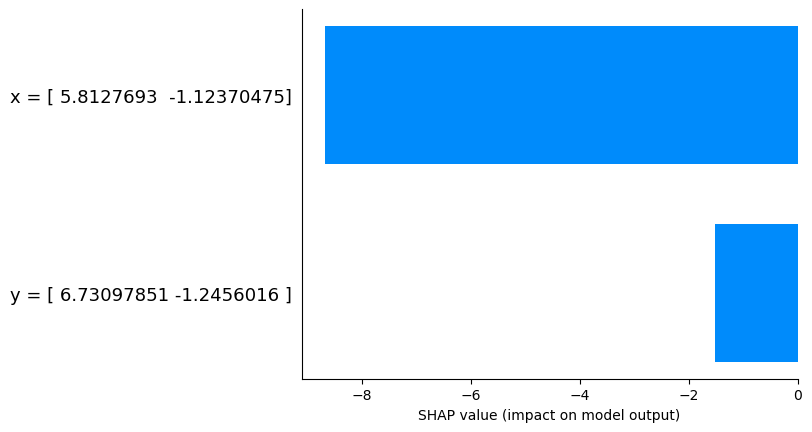

In [41]:
from src.utils.visualisation.deterministic_values import summary_plot, bar_plot, violin_plot
bar_plot(mean_stochastic_shapley_values.T[19], tensor_datasets[19], feature_names=['x', 'y'])

Group 20 (index 19) is not only rotated by 90 degrees it also has its mean shifted by 5 points in the x directly. This shift is contributing the most and the feature x is identified as the modt influential featrue. 

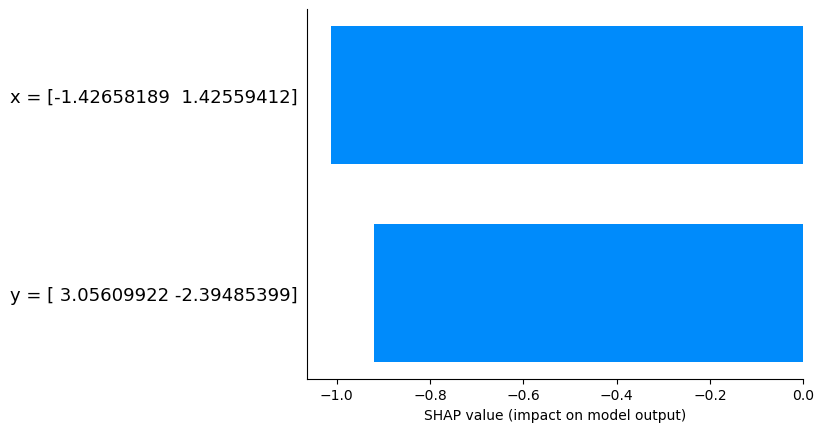

In [42]:
bar_plot(mean_stochastic_shapley_values.T[18], tensor_datasets[18], feature_names=['x', 'y'])

This group has its axis tilted, but the data is still centered at [0,0], so the influence of both are features are almost the same.

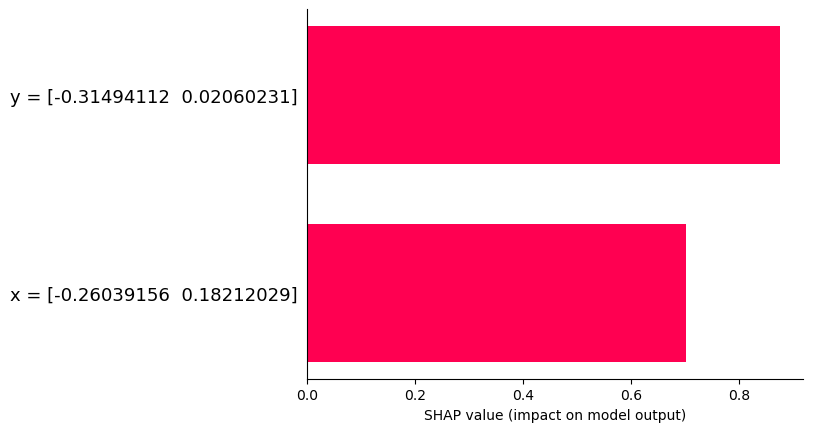

In [43]:
bar_plot(mean_stochastic_shapley_values.T[2], tensor_datasets[2], feature_names=['x', 'y'])

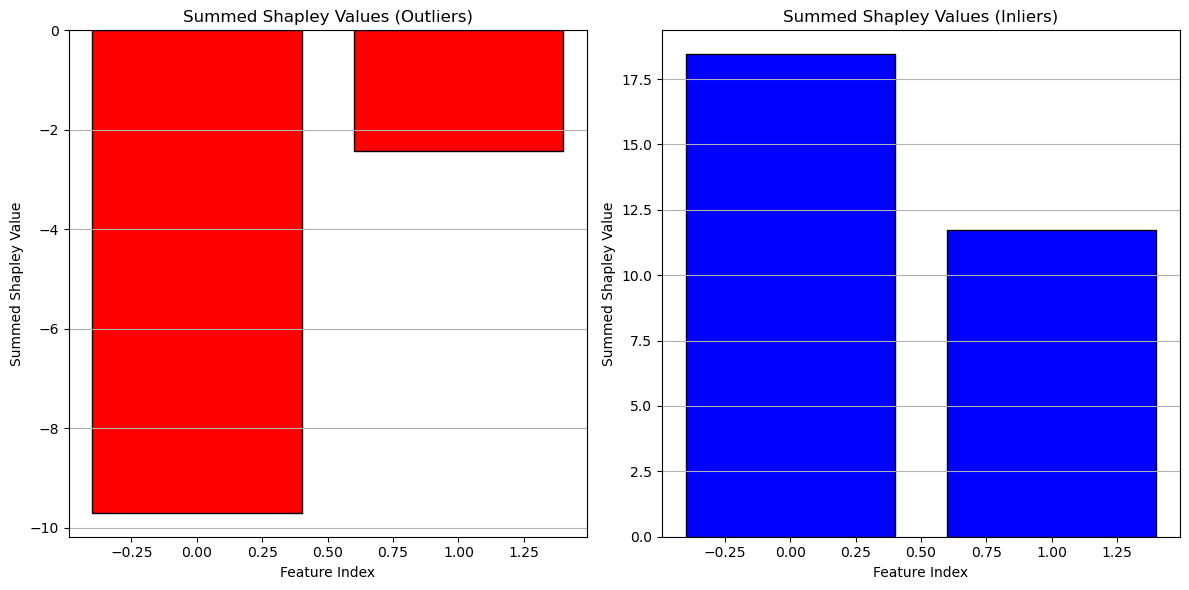

In [45]:
inlier_indices = [i for i in range(mean_stochastic_shapley_values.shape[1]) if i not in outlier_indices]

summed_outlier_shapley = mean_stochastic_shapley_values[:, outlier_indices].sum(dim=1).numpy()
summed_inlier_shapley = mean_stochastic_shapley_values[:, inlier_indices].sum(dim=1).numpy()

# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Outlier Shapley Values
ax[0].bar(range(len(summed_outlier_shapley)), summed_outlier_shapley, color='red', edgecolor='black')
ax[0].set_title('Summed Shapley Values (Outliers)')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Summed Shapley Value')
ax[0].grid(True, axis='y')

# Inlier Shapley Values
ax[1].bar(range(len(summed_inlier_shapley)), summed_inlier_shapley, color='blue', edgecolor='black')
ax[1].set_title('Summed Shapley Values (Inliers)')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Summed Shapley Value')
ax[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

The outliers are moving the decision towards the negative direction, hence their influence is negative.

## Experiment 2 (not important)

In [46]:
import numpy as np
import pandas as pd
# Load dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
wine_data = pd.read_csv(url, sep=';')

# Select only relevant columns (ignoring quality after grouping)
selected_columns = ['alcohol', 'volatile acidity', 'fixed acidity', 'pH', 'quality']
wine_data = wine_data[selected_columns]

# Sort by quality for consistency
wine_data = wine_data.sort_values(by="quality")

# Get unique quality levels
unique_qualities = sorted(wine_data["quality"].unique())

# Assign first and second groups for artificial outliers
group_1_quality = unique_qualities[0]  # First group (smallest quality)
group_2_quality = unique_qualities[1]  # Second group (second smallest quality)


In [47]:
wine_data

,alcohol,volatile acidity,fixed acidity,pH,quality
1478,10.2,0.875,7.1,3.40,3
832,9.9,0.440,10.4,3.38,3
899,11.0,1.020,8.3,3.48,3
1374,9.8,0.815,6.8,3.32,3
459,9.0,0.580,11.6,3.25,3
...,...,...,...,...,...
495,11.0,0.350,10.7,3.15,8
1403,10.0,0.330,7.2,3.23,8
1090,11.8,0.260,10.0,2.98,8
1449,11.3,0.380,7.2,3.23,8


In [52]:
def add_artificial_features(group, is_group_1, is_group_2):
    num_samples = group.shape[0]

    # Normal values (1-5) for artificial features
    artificial_feature_1 = np.random.uniform(1, 5, num_samples)
    artificial_feature_2 = np.random.uniform(1, 5, num_samples)

    if is_group_1:
        artificial_feature_1 = np.random.uniform(50, 55, num_samples)  # High values for group 1
    if is_group_2:
        artificial_feature_2 = np.random.uniform(50, 55, num_samples)  # High values for group 2

    # Drop the quality column and add artificial features
    group = group.drop(columns=['quality'])
    group['artificial_feature_1'] = artificial_feature_1
    group['artificial_feature_2'] = artificial_feature_2

    return group.values  # Convert to NumPy array


In [53]:
wine_groups = [
    add_artificial_features(group, quality == group_1_quality, quality == group_2_quality)
    for quality, group in wine_data.groupby('quality')
]

# Print final structure
for i, group in enumerate(wine_groups):
    print(f"Group {i+1}: {group.shape[0]} samples, {group.shape[1]} features")


Group 1: 10 samples, 6 features
Group 2: 53 samples, 6 features
Group 3: 681 samples, 6 features
Group 4: 638 samples, 6 features
Group 5: 199 samples, 6 features
Group 6: 18 samples, 6 features


In [56]:
wine_groups

[array([[10.2       ,  0.875     ,  7.1       ,  3.4       , 50.2566172 ,
          2.78919984],
        [ 9.9       ,  0.44      , 10.4       ,  3.38      , 52.3189344 ,
          4.15843381],
        [11.        ,  1.02      ,  8.3       ,  3.48      , 51.38545802,
          3.09573729],
        [ 9.8       ,  0.815     ,  6.8       ,  3.32      , 54.07872132,
          4.50391385],
        [ 9.        ,  0.58      , 11.6       ,  3.25      , 53.07203903,
          3.94227058],
        [ 8.4       ,  0.61      , 10.4       ,  3.16      , 51.47466385,
          2.24101142],
        [ 9.7       ,  0.98      ,  7.3       ,  3.31      , 54.03564482,
          4.37679428],
        [10.7       ,  1.185     ,  7.4       ,  3.63      , 54.1339989 ,
          3.74691525],
        [ 9.95      ,  0.76      ,  6.7       ,  3.55      , 51.10747256,
          3.53853761],
        [10.9       ,  1.58      ,  7.6       ,  3.5       , 51.64104815,
          3.36032151]]),
 array([[11.2       ,  1.115

Each group has a different number of samples

In [57]:
classifier = OneClassSMMClassifier(nu=0.1)
decision, y_pred = classifier.fit(wine_groups)

ValueError: operands could not be broadcast together with shapes (10,10) (53,53) 

In [55]:
for i, (score, pred) in enumerate(zip(decision, y_pred)):
    print(f"Group {i+1}: Decision Score = {score:}, Prediction = {pred}")

Group 1: Decision Score = 1.9913773450885195, Prediction = 1.0
Group 2: Decision Score = 1.744945155272072, Prediction = 1.0
Group 3: Decision Score = 1.577572018145304, Prediction = 1.0
Group 4: Decision Score = 0.21506151473926316, Prediction = 1.0
Group 5: Decision Score = 1.3874434476018642, Prediction = 1.0
Group 6: Decision Score = 2.1208090977480936, Prediction = 1.0
Group 7: Decision Score = 1.9097042886494826, Prediction = 1.0
Group 8: Decision Score = 1.2092038632478985, Prediction = 1.0
Group 9: Decision Score = 1.5775755164476166, Prediction = 1.0
Group 10: Decision Score = 1.6463541071248873, Prediction = 1.0
Group 11: Decision Score = 1.5923877372753363, Prediction = 1.0
Group 12: Decision Score = 3.628472125811415, Prediction = 1.0
Group 13: Decision Score = 1.5775720012060752, Prediction = 1.0
Group 14: Decision Score = 1.182108989960831, Prediction = 1.0
Group 15: Decision Score = 2.9535420985142355, Prediction = 1.0
Group 16: Decision Score = 1.4797754812437987, Predi

In [23]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=wine_groups_tensor, classifier=classifier)
ocsmm_shap.fit_ocsmmshap(X=wine_groups_tensor, num_coalitions=2**wine_groups_tensor[0].shape[1])

/Users/swathisuhas/Documents/CISPA/OCSVM-SHAP/OCSVM_SHAP/src/utils/shapley_procedure/coalitions.py:19: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/Users/swathisuhas/Documents/CISPA/OCSVM-SHAP/OCSVM_SHAP/src/utils/shapley_procedure/coalitions.py:19: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
/Users/swathisuhas/Documents/CISPA/OCSVM-SHAP/OCSVM_SHAP/src/utils/shapley_procedure/coalitions.py:19: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)


[0 1 2 5]
[0.1502002  0.07258741 0.0071902  0.13002028]
0.34416003200940626


100%|██████████| 63/63 [00:04<00:00, 14.93it/s]


In [24]:
mean_stochastic_shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [25]:
mean_stochastic_shapley_values

tensor([[ 4.0944e-07,  2.2425e-05, -1.5585e-04,  3.6507e-04,  3.1409e-04,
         -5.3460e-05],
        [-1.8264e-05, -1.4236e-06,  7.5037e-06,  1.6071e-04,  2.0138e-04,
          1.4275e-04],
        [ 5.5154e-06,  3.3528e-05, -4.5032e-05,  2.5342e-04,  2.8264e-04,
         -3.6382e-05],
        [ 2.6319e-05, -3.6788e-06,  1.2671e-04,  1.5544e-04,  1.6560e-04,
          2.3173e-05],
        [-8.9598e-06, -2.2893e-05,  5.1250e-05,  2.3655e-04,  2.7229e-04,
         -3.5425e-05],
        [-3.5764e-06, -1.3456e-05,  1.0946e-04,  2.0878e-04,  2.2330e-04,
         -3.1755e-05]])

the highest value for af1 is with first group
but group 2 has the second highest af2 value and not the highest

all groups have differnt sizes, is it beacuse of that ??

In [26]:
feature_names = ['alcohol', 'volatile acidity', 'fixed acidity', 'pH', 'af1', 'af2']

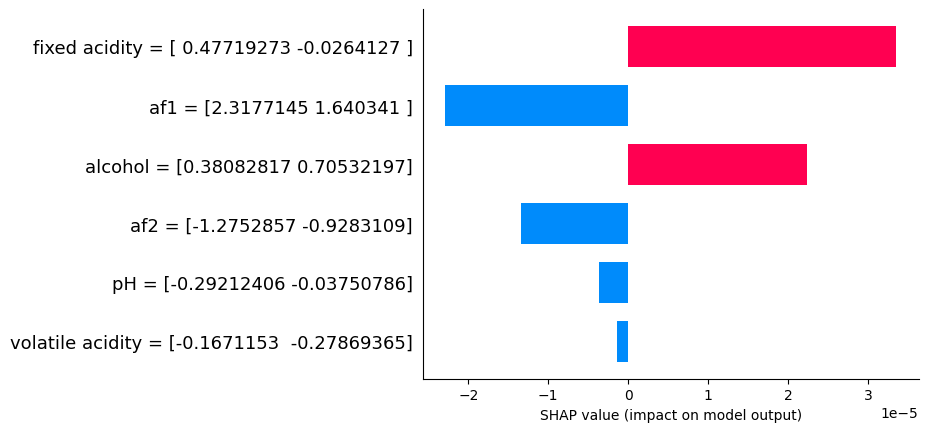

In [27]:
bar_plot(mean_stochastic_shapley_values.T[1], datasets[1], feature_names=feature_names)

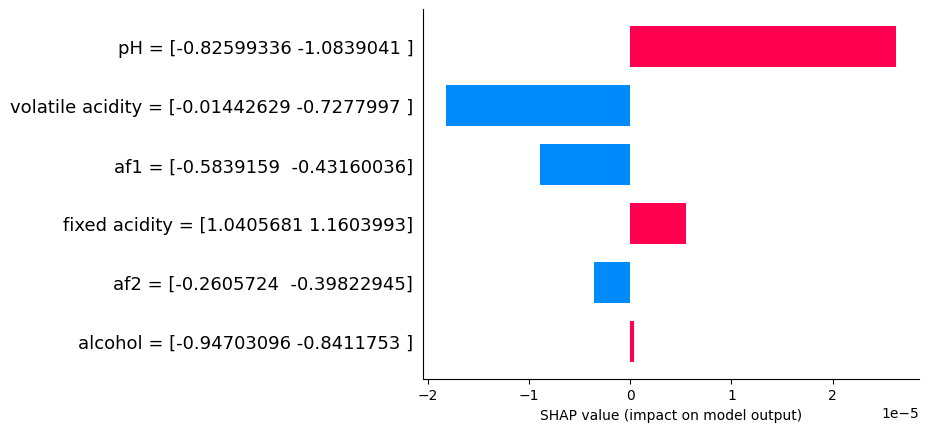

In [28]:
bar_plot(mean_stochastic_shapley_values.T[0], datasets[0], feature_names=feature_names)

## Experiment 3

I have 10 groups, each with 100 points. There are two features. All features are between values of 5 and 10. For one group, we will make all values of first feature between 100 and 120. For the second group, we make all values of second feature between 100 and 120. 
Both of these groups should be identified as outliers. 

In [27]:
def generate_groups():
    # Normal groups (8 groups with normal data)
    normal_groups = []
    for _ in range(8):
        group = np.random.uniform(5, 10, size=(20, 2))  # 100 points, 2 features between 5 and 10
        normal_groups.append(torch.FloatTensor(group))
    
    # Outlier Group 1: Modify first feature to be between 100 and 120
    outlier_group_1 = np.random.uniform(5, 10, size=(20, 1))  # Second feature between 5 and 10
    outlier_group_1 = np.hstack([np.random.uniform(20, 25, size=(20, 1)), outlier_group_1])  # First feature between 100 and 120
    
    # Outlier Group 2: Modify second feature to be between 100 and 120
    outlier_group_2 = np.random.uniform(5, 10, size=(20, 1))  # First feature between 5 and 10
    outlier_group_2 = np.hstack([outlier_group_2, np.random.uniform(20, 25, size=(20, 1))])  # Second feature between 100 and 120
    
    outlier_group_1 = torch.FloatTensor(outlier_group_1)
    outlier_group_2 = torch.FloatTensor(outlier_group_2)
    
    # Combine all groups (8 normal groups + 2 outliers)
    all_groups = [outlier_group_1, outlier_group_2] + normal_groups 
    return all_groups

In [28]:
groups = generate_groups()
groups

[tensor([[24.5114,  5.8903],
         [23.9781,  8.5439],
         [24.9785,  8.4027],
         [24.6265,  7.2500],
         [21.4832,  6.8926],
         [23.9218,  9.1930],
         [22.0381,  8.9254],
         [24.5095,  9.7255],
         [23.8386,  9.9537],
         [23.9066,  8.4921],
         [23.9992,  7.4151],
         [23.5275,  8.5108],
         [20.5152,  8.5532],
         [24.6362,  5.9550],
         [20.4200,  9.8192],
         [21.8495,  6.1972],
         [22.8581,  8.4545],
         [24.7625,  9.9034],
         [22.8771,  8.3778],
         [21.5434,  9.0657]]),
 tensor([[ 9.7323, 22.2547],
         [ 6.1125, 24.0004],
         [ 7.0062, 23.5390],
         [ 9.1523, 23.0234],
         [ 9.8536, 23.7093],
         [ 5.5564, 23.3585],
         [ 8.5385, 22.6358],
         [ 7.7500, 20.9147],
         [ 9.8658, 23.8061],
         [ 5.4432, 22.2392],
         [ 5.3996, 20.3681],
         [ 8.6103, 23.6876],
         [ 6.6528, 24.0292],
         [ 7.9325, 22.8307],
         [ 7

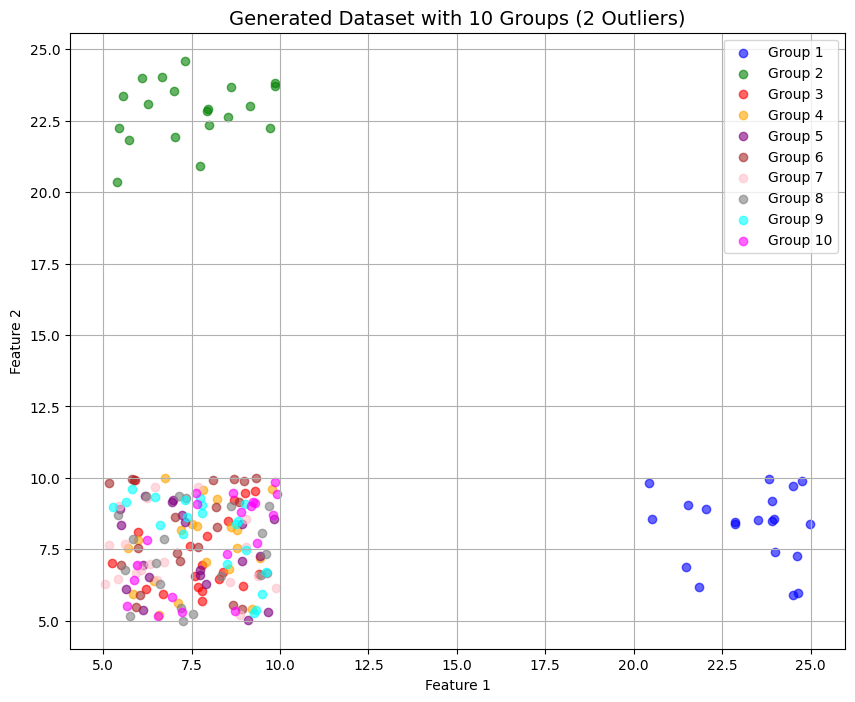

In [29]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']
for i, group in enumerate(groups):
    plt.scatter(group[:, 0], group[:, 1], color=colors[i], label=f'Group {i+1}', alpha=0.6)

plt.title("Generated Dataset with 10 Groups (2 Outliers)", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [30]:
classifier = OneClassSMMClassifier(groups, nu=0.2,gamma_x=0.3, gamma_d=0.2)

In [31]:
decision, y_pred = classifier.fit()


[0 1 2 6 8 9]
[0.60161221 0.61927266 0.30550014 0.07251172 0.38319613 0.01790709]
1.8207991095495029


In [32]:
for i, (score, pred) in enumerate(zip(decision, y_pred)):
    print(f"Group {i+1}: Decision Score = {score:}, Prediction = {pred}")

Group 1: Decision Score = -2.7941578912837883e-06, Prediction = -1.0
Group 2: Decision Score = -2.794057298416419e-06, Prediction = -1.0
Group 3: Decision Score = -2.7987809483320802e-06, Prediction = -1.0
Group 4: Decision Score = 0.014920540964895146, Prediction = 1.0
Group 5: Decision Score = 0.02234602150754772, Prediction = 1.0
Group 6: Decision Score = 0.02065196316673812, Prediction = 1.0
Group 7: Decision Score = -2.7917557225975997e-06, Prediction = -1.0
Group 8: Decision Score = 0.023081938366265042, Prediction = 1.0
Group 9: Decision Score = -2.7984945263348493e-06, Prediction = -1.0
Group 10: Decision Score = 0.0, Prediction = 0.0


In [33]:
# import itertools
# def grid_search_gamma(datasets, nu=0.1, gamma_x_values=None, gamma_d_values=None):
#     """Performs grid search over gamma_x and gamma_d to find optimal values."""
    
#     if gamma_x_values is None:
#         gamma_x_values = np.logspace(-3, 2, 6)  # Range: [0.001, 100]
    
#     if gamma_d_values is None:
#         gamma_d_values = np.logspace(-3, 2, 6)  # Range: [0.001, 100]

#     best_params = None
#     best_score = float('inf')  # Initialize with a high number
#     results = []

#     # Iterate over all combinations of gamma_x and gamma_d
#     for gamma_x, gamma_d in itertools.product(gamma_x_values, gamma_d_values):
#         # print(f"Testing gamma_x={gamma_x}, gamma_d={gamma_d}...")

#         # Train One-Class SMM with current parameters
#         classifier = OneClassSMMClassifier(
#             datasets=datasets,
#             nu=nu,
#             gamma_x=gamma_x,
#             gamma_d=gamma_d
#         )

#         # Get predictions
#         decision, predictions = classifier.fit()

#         num_outliers = np.sum(predictions == -1)

#         # Store results only if we have 1, 2, or 3 outliers
#         if num_outliers in {1, 2, 3}:
#             results.append((gamma_x, gamma_d, num_outliers))
#             print(f"gamma_x={gamma_x:.5f}, gamma_d={gamma_d:.5f}, group1={predictions[0]}, group2={predictions[1]} -> Outliers Detected: {num_outliers}")

#             # If exactly 2 outliers, save as best parameters
#             if num_outliers == 2 and best_params is None:
#                 best_params = (gamma_x, gamma_d)

#     if not results:
#         print("\nNo hyperparameter settings resulted in 1, 2, or 3 outliers.")

#     return best_params, results

# grid_search_gamma(datasets)

## Experiment 3